# **decision tree / random Forest**


### Table of Contents
1. Data Validation
2. Encoding
   - 2.1. Ordinal Encoding of Ordinal Variables
   - 2.2. OneHotEncoding for Single-Select Nominal Features
   - 2.3. OneHotEncoding for Multi-Select Features ("Recycling" and "Cooking_With")
3. model: Decision Tree Regression
   - 3.1. Model Training 
   - 3.2. Top Hyperparameter Combinations
   - 3.3. Model Evaluation
   - 3.4. see the Tree
   - 3.5. prediction
   - 3.6. Model Export to pkl-file


In [17]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RepeatedKFold, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score


df=pd.read_csv('Carbon_Emission.csv',sep=";")

# change display settings to show all columns
pd.set_option('display.max_columns', None)


#rename
# rename columns: replace spaces with underscores
df.columns = df.columns.str.replace(' ', '_')
# data.columns = data.columns.str.replace(' ', '_').str.lower()
# Rename 'public' to 'public transport' and the car-typs - to make the information easier to understand
df['Vehicle_Type'] = df['Vehicle_Type'].replace({'public': 'public transport', 'petrol': 'car (type: petrol)','diesel': 'car (type: diesel)',
                                                'hybrid': 'car (type: hybrid)','lpg': 'car (type: lpg)','electric': 'car (type: electric)'})
df['Transport'] = df['Transport'].replace({'public': 'public transport', 'private': 'car'})


df.head()

,Body_Type,Sex,Diet,How_Often_Shower,Heating_Energy_Source,Transport,Vehicle_Type,Social_Activity,Monthly_Grocery_Bill,Frequency_of_Traveling_by_Air,Vehicle_Monthly_Distance_Km,Waste_Bag_Size,Waste_Bag_Weekly_Count,How_Long_TV_PC_Daily_Hour,How_Many_New_Clothes_Monthly,How_Long_Internet_Daily_Hour,Energy_efficiency,Recycling,Cooking_With,CarbonEmission
0,overweight,female,pescatarian,daily,coal,public transport,NaN,often,230,frequently,210,large,4,7,26,1,No,['Metal'],"['Stove', 'Oven']",2238
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,NaN,often,114,rarely,9,extra large,3,9,38,5,No,['Metal'],"['Stove', 'Microwave']",1892
2,overweight,male,omnivore,more frequently,wood,car,car (type: petrol),never,138,never,2472,small,1,14,47,6,Sometimes,['Metal'],"['Oven', 'Microwave']",2595
3,overweight,male,omnivore,twice a day,wood,walk/bicycle,NaN,sometimes,157,rarely,74,medium,3,20,5,7,Sometimes,"['Paper', 'Plastic', 'Glass', 'Metal']","['Microwave', 'Grill', 'Airfryer']",1074
4,obese,female,vegetarian,daily,coal,car,car (type: diesel),often,266,very frequently,8457,large,1,3,5,6,Yes,['Paper'],['Oven'],4743


# 1. Data Validation

in simulating the data set the creators seemed to have linked the use of a cooking with grill and the use of an airfryer. Consequently, we excluded the airfryer from the variables, as it did not contain any additional information. We found this out by doing a correlation matrix for the dummy-variables.

In [18]:

# Remove "Airfryer" from the 'Cooking_With'-variable
df['Cooking_With'] = df['Cooking_With'].str.replace(", 'Airfryer'", "") 

# Check if the removal was successful
unique_values_cooking_With= set([item for sublist in df['Cooking_With'].unique() for item in eval(sublist)]) # Create a set of all unique "Cooking_With" options
print(unique_values_cooking_With)   

{'Oven', 'Microwave', 'Grill', 'Stove'}


# **2. Encoding**


| variable type| variables | encoding  |
| -----------  | ----------- | ----------- |
| target variable |  CarbonEmission |   |
| Quantitative Variables |  Monthly Grocery Bill, Vehicle Monthly Distance Km, Waste Bag Weekly Count, How Long TV, PC Daily, Hour How Many New Clothes Monthly, How Long Internet Daily Hour |   |
| Ordinal Variables | Body_Type, Diet, How_Often_Shower, Social_Activity, Frequency_of_Traveling_by_Air, Waste_Bag_Size, Energy_efficiency | Ordinal Encoding (*) |
| Nominal Variables, with one answer | 'Sex', 'Heating_Energy_Source', 'Transport', 'Vehicle Type' | OneHotEncoder (drop 'Sex_female' and drop NaN in 'Vehicle Type') |
| Nominal Variables, with multiple (or zero) answers  | Recycling, Cooking_With | OneHotEncoder |

(*) we want for Body-type:'underweight'=0, 'normal'=1, 'overweight'=2, 'obese'=3. with OrdinalEncoder of Scikit-learn we get: normal: 0, obese: 1, overweight: 2, underweigt: 3 - that would be wrong. chatGPT said there is no tool in Scikit-learn to help me so i do the encoding manually

### 2.1 Ordinal Encoding of Ordinal Variables

In [19]:
#to see the Encoding
df.tail()

,Body_Type,Sex,Diet,How_Often_Shower,Heating_Energy_Source,Transport,Vehicle_Type,Social_Activity,Monthly_Grocery_Bill,Frequency_of_Traveling_by_Air,Vehicle_Monthly_Distance_Km,Waste_Bag_Size,Waste_Bag_Weekly_Count,How_Long_TV_PC_Daily_Hour,How_Many_New_Clothes_Monthly,How_Long_Internet_Daily_Hour,Energy_efficiency,Recycling,Cooking_With,CarbonEmission
9995,obese,male,omnivore,twice a day,coal,car,car (type: hybrid),sometimes,230,never,268,medium,5,12,27,9,Yes,[],['Microwave'],2408
9996,normal,female,vegan,twice a day,coal,car,car (type: lpg),never,234,frequently,5316,extra large,3,14,8,24,Sometimes,"['Paper', 'Plastic']","['Stove', 'Microwave']",3084
9997,overweight,female,vegetarian,daily,electricity,walk/bicycle,NaN,sometimes,298,very frequently,96,extra large,5,11,5,24,Yes,"['Paper', 'Plastic', 'Metal']","['Microwave', 'Grill']",2377
9998,underweight,male,vegan,more frequently,coal,car,car (type: petrol),often,179,rarely,8688,medium,5,19,14,5,Sometimes,"['Paper', 'Metal']","['Stove', 'Microwave', 'Grill']",4574
9999,obese,male,pescatarian,twice a day,wood,car,car (type: electric),sometimes,115,never,9952,small,4,11,6,0,Sometimes,"['Plastic', 'Glass', 'Metal']","['Oven', 'Grill']",826


In [20]:
# error-potential: this makes NaN if run a second time 

#ordering values of ordinal variables
dict_variables_ordinal_categorical = {
    'Body_Type': ['underweight', 'normal', 'overweight', 'obese'],
    'Diet': ['vegan','vegetarian','pescatarian','omnivore'],
    'How_Often_Shower': ['less frequently','daily', 'twice a day','more frequently'],
    'Social_Activity': ['never', 'sometimes','often'],
    'Frequency_of_Traveling_by_Air': ['never', 'rarely', 'frequently', 'very frequently'],
    'Waste_Bag_Size': ['small','medium', 'large', 'extra large'],
    'Energy_efficiency': ['Yes', 'Sometimes', 'No']
}

# Custom mapping for ordinal encoding based on defined order
for column, column_ordering in dict_variables_ordinal_categorical.items():
   mapping = {category: idx for idx, category in enumerate(column_ordering)}
   df[column] = df[column].map(mapping)

#to see the Encoding
df.tail()

,Body_Type,Sex,Diet,How_Often_Shower,Heating_Energy_Source,Transport,Vehicle_Type,Social_Activity,Monthly_Grocery_Bill,Frequency_of_Traveling_by_Air,Vehicle_Monthly_Distance_Km,Waste_Bag_Size,Waste_Bag_Weekly_Count,How_Long_TV_PC_Daily_Hour,How_Many_New_Clothes_Monthly,How_Long_Internet_Daily_Hour,Energy_efficiency,Recycling,Cooking_With,CarbonEmission
9995,3,male,3,2,coal,car,car (type: hybrid),1,230,0,268,1,5,12,27,9,0,[],['Microwave'],2408
9996,1,female,0,2,coal,car,car (type: lpg),0,234,2,5316,3,3,14,8,24,1,"['Paper', 'Plastic']","['Stove', 'Microwave']",3084
9997,2,female,1,1,electricity,walk/bicycle,NaN,1,298,3,96,3,5,11,5,24,0,"['Paper', 'Plastic', 'Metal']","['Microwave', 'Grill']",2377
9998,0,male,0,3,coal,car,car (type: petrol),2,179,1,8688,1,5,19,14,5,1,"['Paper', 'Metal']","['Stove', 'Microwave', 'Grill']",4574
9999,3,male,2,2,wood,car,car (type: electric),1,115,0,9952,0,4,11,6,0,1,"['Plastic', 'Glass', 'Metal']","['Oven', 'Grill']",826


### 2.2 OneHotEncoding for Single-Select Nominal Features


In [21]:
#makes an error if run 2 times because original columns are gone

#creaty dummy-variables
df = pd.get_dummies(df, columns=['Sex'], drop_first=True) #drop of first column
df = pd.get_dummies(df, columns=['Transport', 'Heating_Energy_Source']) 
df = pd.get_dummies(df, columns=['Vehicle_Type'], dummy_na=False)  #dummy_na=False: Prevents the creation of dummy variables for NaN values.


df.head()

,Body_Type,Diet,How_Often_Shower,Social_Activity,Monthly_Grocery_Bill,Frequency_of_Traveling_by_Air,Vehicle_Monthly_Distance_Km,Waste_Bag_Size,Waste_Bag_Weekly_Count,How_Long_TV_PC_Daily_Hour,How_Many_New_Clothes_Monthly,How_Long_Internet_Daily_Hour,Energy_efficiency,Recycling,Cooking_With,CarbonEmission,Sex_male,Transport_car,Transport_public transport,Transport_walk/bicycle,Heating_Energy_Source_coal,Heating_Energy_Source_electricity,Heating_Energy_Source_natural gas,Heating_Energy_Source_wood,Vehicle_Type_car (type: diesel),Vehicle_Type_car (type: electric),Vehicle_Type_car (type: hybrid),Vehicle_Type_car (type: lpg),Vehicle_Type_car (type: petrol)
0,2,2,1,2,230,2,210,2,4,7,26,1,2,['Metal'],"['Stove', 'Oven']",2238,False,False,True,False,True,False,False,False,False,False,False,False,False
1,3,1,0,2,114,1,9,3,3,9,38,5,2,['Metal'],"['Stove', 'Microwave']",1892,False,False,False,True,False,False,True,False,False,False,False,False,False
2,2,3,3,0,138,0,2472,0,1,14,47,6,1,['Metal'],"['Oven', 'Microwave']",2595,True,True,False,False,False,False,False,True,False,False,False,False,True
3,2,3,2,1,157,1,74,1,3,20,5,7,1,"['Paper', 'Plastic', 'Glass', 'Metal']","['Microwave', 'Grill']",1074,True,False,False,True,False,False,False,True,False,False,False,False,False
4,3,1,1,2,266,3,8457,2,1,3,5,6,0,['Paper'],['Oven'],4743,False,True,False,False,True,False,False,False,True,False,False,False,False


### 2.3 OneHotEncoding for Multi-Select Features ("Recycling" and "Cooking_With")

In [22]:
# Function to create dummy variables for a given column that has multi-select features
def create_dummy_variables(df, column_name):

    # Extract unique values from the column
    unique_values = {item for sublist in df[column_name].unique() for item in eval(sublist)}
    
    # Create dummy variables for each unique value
    for item in unique_values:
        df[f'{column_name}_{item}'] = df[column_name].apply(lambda x: 1 if item in x else 0)
    
    # Drop the original column after creating dummy variables
    df = df.drop([column_name], axis=1)

    return df


# Generate dummy variables for Recycling and Cooking_With columns
df = create_dummy_variables(df, 'Recycling')
df = create_dummy_variables(df, 'Cooking_With')


df.head()

,Body_Type,Diet,How_Often_Shower,Social_Activity,Monthly_Grocery_Bill,Frequency_of_Traveling_by_Air,Vehicle_Monthly_Distance_Km,Waste_Bag_Size,Waste_Bag_Weekly_Count,How_Long_TV_PC_Daily_Hour,How_Many_New_Clothes_Monthly,How_Long_Internet_Daily_Hour,Energy_efficiency,CarbonEmission,Sex_male,Transport_car,Transport_public transport,Transport_walk/bicycle,Heating_Energy_Source_coal,Heating_Energy_Source_electricity,Heating_Energy_Source_natural gas,Heating_Energy_Source_wood,Vehicle_Type_car (type: diesel),Vehicle_Type_car (type: electric),Vehicle_Type_car (type: hybrid),Vehicle_Type_car (type: lpg),Vehicle_Type_car (type: petrol),Recycling_Paper,Recycling_Glass,Recycling_Plastic,Recycling_Metal,Cooking_With_Oven,Cooking_With_Microwave,Cooking_With_Grill,Cooking_With_Stove
0,2,2,1,2,230,2,210,2,4,7,26,1,2,2238,False,False,True,False,True,False,False,False,False,False,False,False,False,0,0,0,1,1,0,0,1
1,3,1,0,2,114,1,9,3,3,9,38,5,2,1892,False,False,False,True,False,False,True,False,False,False,False,False,False,0,0,0,1,0,1,0,1
2,2,3,3,0,138,0,2472,0,1,14,47,6,1,2595,True,True,False,False,False,False,False,True,False,False,False,False,True,0,0,0,1,1,1,0,0
3,2,3,2,1,157,1,74,1,3,20,5,7,1,1074,True,False,False,True,False,False,False,True,False,False,False,False,False,1,1,1,1,0,1,1,0
4,3,1,1,2,266,3,8457,2,1,3,5,6,0,4743,False,True,False,False,True,False,False,False,True,False,False,False,False,1,0,0,0,1,0,0,0


# **3. model: Decision Tree Regression**

### 3.1 Model Training

In [23]:
X = df.drop(["CarbonEmission"],axis=1)

y = df["CarbonEmission"]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X,y,train_size=0.75,)

clf = GridSearchCV(DecisionTreeRegressor(), param_grid = {
    'max_depth': [9,12,15],
    'min_samples_leaf': [30,50] #werden nicht mehr aufgeteilt wenn nur noch x Leute noch drinnen sind
}, cv = RepeatedKFold(n_splits = 4)) 

clf.fit(X_train2, y_train2)

clf

GridSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=4, random_state=None),
             estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [9, 12, 15],
                         'min_samples_leaf': [30, 50]})

### 3.2 Top Hyperparameter Combinations
This section outputs the top 10 hyperparameter combinations based on the rank of the test scores after performing cross-validation.

In [24]:
#Hyperparameter
pd.DataFrame(clf.cv_results_)[['rank_test_score','mean_test_score','param_max_depth','param_min_samples_leaf']].sort_values(by='rank_test_score').head(10)


,rank_test_score,mean_test_score,param_max_depth,param_min_samples_leaf
2,1,0.822593,12,30
4,1,0.822593,15,30
0,3,0.821542,9,30
3,4,0.805471,12,50
5,4,0.805471,15,50
1,6,0.805282,9,50


### 3.3 Model Evaluation 

In [25]:
 
# Predict the target variable for the training and test sets
y_train_pred2 = clf.predict(X_train2)
y_test_pred2 = clf.predict(X_test2)

# Create a DataFrame with the results
pd.DataFrame({
    'R-squared': [
        r2_score(y_train2, y_train_pred2),
        r2_score(y_test2, y_test_pred2)
    ],
    'Mean Squared Error': [
        mean_squared_error(y_train2, y_train_pred2),
        mean_squared_error(y_test2, y_test_pred2)
    ]
}, index=['Training Set Evaluation', 'Test Set Evaluation'])

,R-squared,Mean Squared Error
Training Set Evaluation,0.872776,131469.806478
Test Set Evaluation,0.842853,163740.857964


### 3.4 see the Tree

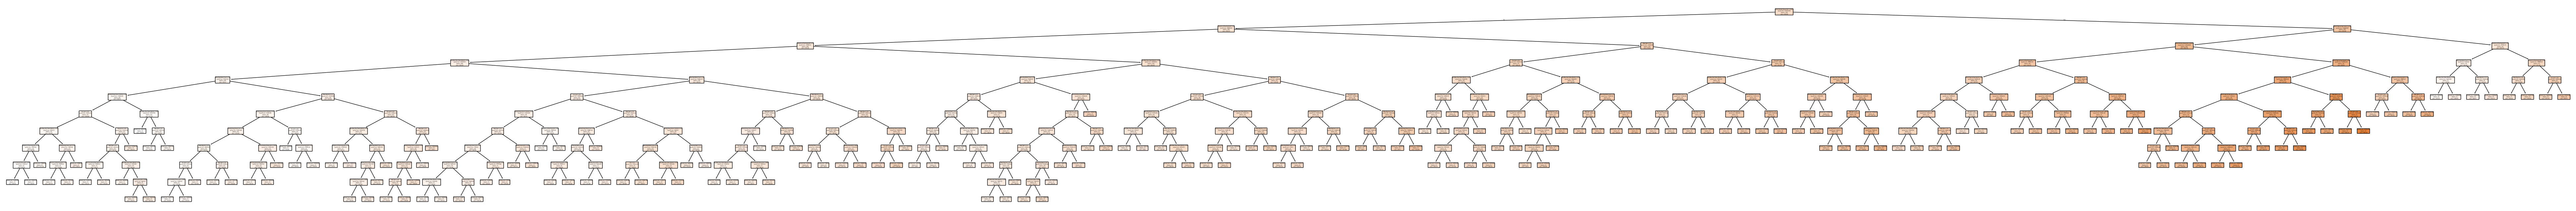

In [26]:
#chatGPT did the programming for me

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt


#ich bin mir nicht sicher ob das hier stimmt!!!
# Beste Parameter aus GridSearchCV verwenden
best_model = clf.best_estimator_

# Plot the decision tree
plt.figure(figsize=(100, 8))
plot_tree(best_model, filled=True, feature_names=X.columns, rounded=True)
plt.show()



### 3.5 prediction

In [27]:
#for (max_depth=3, min_samples_leaf=5) - people in the 2nd box from the right:
filtered_df = df[
    (df['Vehicle_Monthly_Distance_Km'] > 3219) &
    (df['Vehicle_Type_car (type: electric)'] == True) &
    (df['Frequency_of_Traveling_by_Air'] <= 1.5)
]

# loc[:, X.columns] = Select the relevant columns based on X.columns  - otherwise i will get an error-message
X_pred = filtered_df.loc[:, X.columns].head()
y_pred = clf.predict(X_pred)
print("Predicted CarbonEmission: ", y_pred)


y_actual = list(filtered_df.loc[:, 'CarbonEmission'].head())
print("actual CarbonEmission:", y_actual)


Predicted CarbonEmission:  [1469.87096774 1442.06976744 1072.91666667 1785.17857143 1469.87096774]


,Body_Type,Diet,How_Often_Shower,Social_Activity,Monthly_Grocery_Bill,Frequency_of_Traveling_by_Air,Vehicle_Monthly_Distance_Km,Waste_Bag_Size,Waste_Bag_Weekly_Count,How_Long_TV_PC_Daily_Hour,How_Many_New_Clothes_Monthly,How_Long_Internet_Daily_Hour,Energy_efficiency,CarbonEmission,Sex_male,Transport_car,Transport_public transport,Transport_walk/bicycle,Heating_Energy_Source_coal,Heating_Energy_Source_electricity,Heating_Energy_Source_natural gas,Heating_Energy_Source_wood,Vehicle_Type_car (type: diesel),Vehicle_Type_car (type: electric),Vehicle_Type_car (type: hybrid),Vehicle_Type_car (type: lpg),Vehicle_Type_car (type: petrol),Recycling_Paper,Recycling_Glass,Recycling_Plastic,Recycling_Metal,Cooking_With_Oven,Cooking_With_Microwave,Cooking_With_Grill,Cooking_With_Stove
46,0,2,0,0,209,0,9555,2,2,13,43,3,0,1188,True,True,False,False,False,False,False,True,False,True,False,False,False,1,1,0,1,1,1,1,0
111,1,0,1,0,162,1,9159,0,7,2,26,16,2,1122,False,True,False,False,False,True,False,False,False,True,False,False,False,0,0,0,0,0,1,0,0
124,1,2,3,2,146,1,3276,3,1,13,10,10,2,877,False,True,False,False,False,False,False,True,False,True,False,False,False,1,1,1,1,0,1,0,1
138,2,2,3,1,247,0,8219,3,5,18,2,5,1,1708,True,True,False,False,False,False,False,True,False,True,False,False,False,0,1,0,0,1,0,0,1
149,3,3,0,2,125,0,5168,0,3,1,40,17,2,1552,False,True,False,False,False,False,True,False,False,True,False,False,False,1,0,1,0,1,0,0,1


In [31]:
X_pred= df.loc[0:1, X.columns] #first 2 persons
y_pred = clf.predict(X_pred)
print("predicted CarbonEmission of first 2 persons: ", y_pred)

y_actual= list(df.loc[0:1, 'CarbonEmission']) #first 2 persons
print("actual CarbonEmission of first 2 persons: ", y_actual)

predicted CarbonEmission of first 2 persons:  [2283.76190476 1636.77777778]
actual CarbonEmission of first 2 persons:  2238 1892


### 3.6 export the model in pkl-file

In [28]:
# chatGPT did the programming

import pickle

#with open('model_decision_tree.pkl', 'wb') as model_file: #Modell
#    pickle.dump(model, model_file)